# **Regresión de Ridge**

## **1. Importación de librerías y carga del dataset**

#### **1.1. Importación de librerías**

In [20]:
# Análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de sticky-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  # Para división de datos y validación
from sklearn.linear_model import Ridge                
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Para preprocesamiento
from sklearn.compose import ColumnTransformer          # Para aplicar transformaciones a columnas específicas
from sklearn.pipeline import Pipeline                  # Para encadenar pasos de preprocesamiento y modelado
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas de evaluación

# Otras utilidades
import math
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

#### **1.2. Cargar el dataset**

In [21]:
df = pd.read_csv('../data/train_es_clean.csv')

# Mostramos información básica sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Visualizamos primeras filas
print("\nVisualización de las primeras filas:")
display(df.head())

Dimensiones del dataset: (1460, 81)
Número de filas: 1460
Número de columnas: 81

Visualización de las primeras filas:


,Id,TipoDeClaseMS,ZonificaciónMS,FrenteLote,ÁreaLote,Calle,Callejón,FormaLote,ContornoTerreno,Servicios,...,ÁreaPiscina,CalidadPiscina,Cerca,CaracterísticaExtra,ValorExtra,MesVenta,AñoVenta,TipoVenta,CondiciónVenta,PrecioVenta
0,1,60,RL,65.0,8450,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,12,2008,WD,Normal,250000


## **2. Exploración inicial de los datos**

#### **2.1. Estadñisticas descriptivas**

In [22]:
# Mostramos las dimensiones y un resumen básico del dataset
print("Dimensiones del dataset:", df.shape)
print(f"Número de propiedades (filas): {df.shape[0]}")
print(f"Número de características (columnas): {df.shape[1]}")

# Estadísticas descriptivas de la variable objetivo
print("\nEstadísticas descriptivas de PrecioVenta:")
precio_stats = df['PrecioVenta'].describe()
print(precio_stats)

Dimensiones del dataset: (1460, 81)
Número de propiedades (filas): 1460
Número de características (columnas): 81

Estadísticas descriptivas de PrecioVenta:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: PrecioVenta, dtype: float64


#### **2.2. Visualización de la distribución de precios**

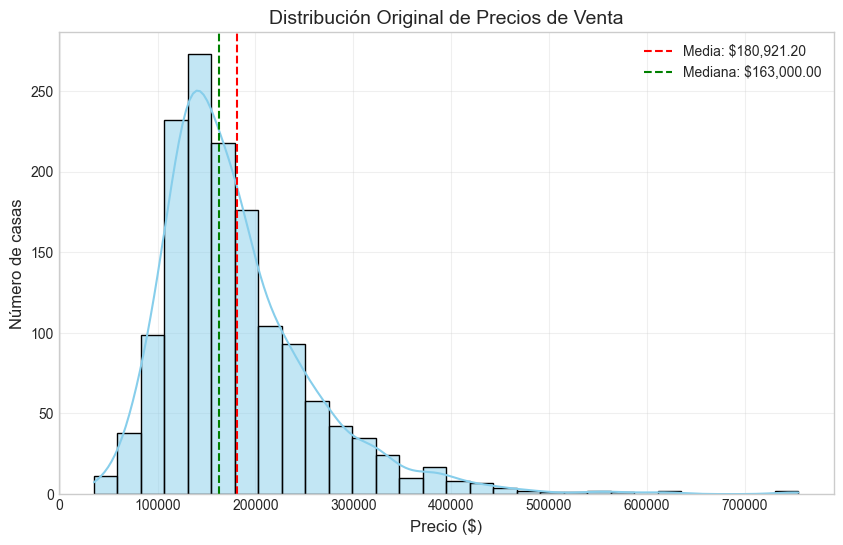

In [23]:
plt.figure(figsize=(10, 6))  
sns.histplot(df['PrecioVenta'], bins=30, kde=True, color='skyblue')  
plt.axvline(precio_stats['mean'], color='red', linestyle='--', 
            label=f'Media: ${precio_stats["mean"]:,.2f}')  
plt.axvline(precio_stats['50%'], color='green', linestyle='--', 
            label=f'Mediana: ${precio_stats["50%"]:,.2f}')  
plt.title('Distribución Original de Precios de Venta', fontsize=14)  
plt.xlabel('Precio ($)', fontsize=12)  
plt.ylabel('Número de casas', fontsize=12)  
plt.legend()  
plt.grid(True, alpha=0.3)  
plt.show()  

<small>

Interpretación:
1. Asimetría positiva (sesgo a la derecha): La distribución muestra una clara cola larga hacía la derecha. La mayoría de precios están entre 100.000 y 200.000.
2. Diferencia entre media y mediana: La media es mayor que la mediana, confirmando matetmáticamente la asimetría positiva. Los valores extremadamente positivos suben la media, mientras que la mediana es más robusta frente a outliers.
3. Concentración de los datos: Mayor densidad de propiedades se encuentran en el rango entre 125.000 - 200.000, con un pico en el medio de 150.000.
4. Rango amplio: La distribución muestra una amplia gama de precios, con una mayor concentración de precios por debajo de 300.000 y una menor concentración de precios por encima de 500.000.

</small>

#### **2.3. Cálculo de asimetría y curtosis**

In [24]:
asimetria = df['PrecioVenta'].skew()
curtosis = df['PrecioVenta'].kurtosis()

print(f"Asimetria (skewness) de PrecioVenta: {asimetria:.4f}")
print(f"Curtosis de PrecioVenta: {curtosis:.4f}")

Asimetria (skewness) de PrecioVenta: 1.8829
Curtosis de PrecioVenta: 6.5363


<small>

Con el cálculo de asimetría y curtosis confirmamos lo visto en el histograma:
1. Asimetría (1.8829): Distribución fuertemente sesgada hacía la derecha. Muchas propiedades de precio  bajo-medio y relativamente pocas de precio alto que estiran la distribución.
2. Curtosis (6.5363): Distribución más puntiaguda de lo normal con colas más pesadas (distribución leptocúrtica)

Es recomendable hacer una transformación logarítmica de la variable objetivo con el objetivo de:
1. "Comprimir" los valores altos, reduciendo la asimetría.
2. Hacer que la la relación entre las variables independientes y el precio sea más lineal.
3. Estabilizar la varianza de los residuos.
4. Mejorar la precisión del modelo, especialmente para las propiedades de precio más bajo.

</small>

#### **2.4. Transformación logarítmica de la variable objetivo**


Estadísticas descriptivas de PrecioVenta (transformación logarítmica):
count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: PrecioVenta_Log, dtype: float64


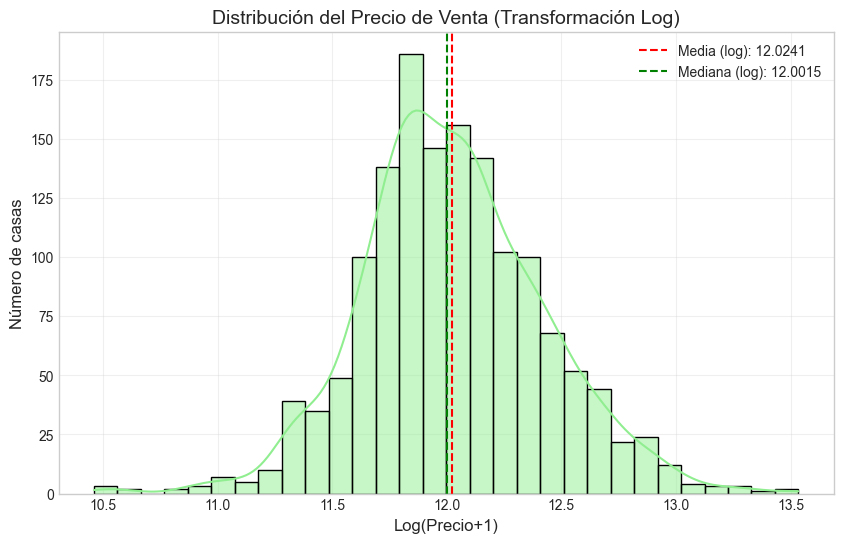


Asimetría después de transformación logarítmica: 0.1213
Curtosis después de transformación logarítmica: 0.8095


In [27]:
# Aplicamos transformación logarítmica y visualizamos
# Utilizamos log1p (log(1+x)) en lugar de log para manejar posibles valores cero
df['PrecioVenta_Log'] = np.log1p(df['PrecioVenta'])

# Mostramos estadísticas descriptivas después de la transformación
print("\nEstadísticas descriptivas de PrecioVenta (transformación logarítmica):")
print(df['PrecioVenta_Log'].describe())

# Visualizamos la distribución después de la transformación
plt.figure(figsize=(10, 6))
sns.histplot(df['PrecioVenta_Log'], bins=30, kde=True, color='lightgreen')
plt.axvline(df['PrecioVenta_Log'].mean(), color='red', linestyle='--', 
            label=f'Media (log): {df["PrecioVenta_Log"].mean():.4f}')
plt.axvline(df['PrecioVenta_Log'].median(), color='green', linestyle='--', 
            label=f'Mediana (log): {df["PrecioVenta_Log"].median():.4f}')
plt.title('Distribución del Precio de Venta (Transformación Log)', fontsize=14)
plt.xlabel('Log(Precio+1)', fontsize=12)
plt.ylabel('Número de casas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculamos la asimetría y curtosis después de la transformación
asimetria_log = df['PrecioVenta_Log'].skew()
curtosis_log = df['PrecioVenta_Log'].kurtosis()
print(f"\nAsimetría después de transformación logarítmica: {asimetria_log:.4f}")
print(f"Curtosis después de transformación logarítmica: {curtosis_log:.4f}")

<small>

Interpretación de la Transformación Logarítmica

La transformación logarítmica ha mejorado drasticamente la distribución de nuestra variable objetivo:

1. Forma: Ahora tenemos una distribución casi simétrica en forma de campana, mucho más cercana a una normal.
2. Media y mediana: Las líneas vertical roja (media: 12.02) y verde (mediana: 12.00) están ahora prácticamente superpuestas, confirmando la simetría.
3. Métricas estadísticas: La asimetría se redujo de 1.88 a solo 0.12, y la curtosis bajó de 6.54 a 0.81, ambos valores mucho más cercanos a lo esperado en una distribución normal.
4. Beneficios para nuestro modelo Ridge: Esta transformación permitirá que nuestro modelo cumpla mejor con los supuestos estadísticos, sea menos sensible a valores extremos y ofrezca predicciones más precisas en todo el rango de precios.

</small>

## **3. Análisis de Variables Predictoras**

#### **3.1. Variables numéricas importantes**

Correlaciones con el precio transformado (log):
PrecioVenta_Log                 1.000000
CalidadGeneral                  0.817185
MetrosHabitables                0.700927
CochesGaraje                    0.680625
ÁreaGaraje                      0.650888
MetrosTotalesSótano             0.612134
Metros1raPlanta                 0.596981
BañosCompletos                  0.594771
AñoConstrucción                 0.586570
AñoRenovación                   0.565608
TotalHabitacionesSobreSuelo     0.534422
Chimeneas                       0.489450
ÁreaRevestimientoMampostería    0.426776
MetrosAcabadosSótano1           0.372023
FrenteLote                      0.335292
Name: PrecioVenta_Log, dtype: float64


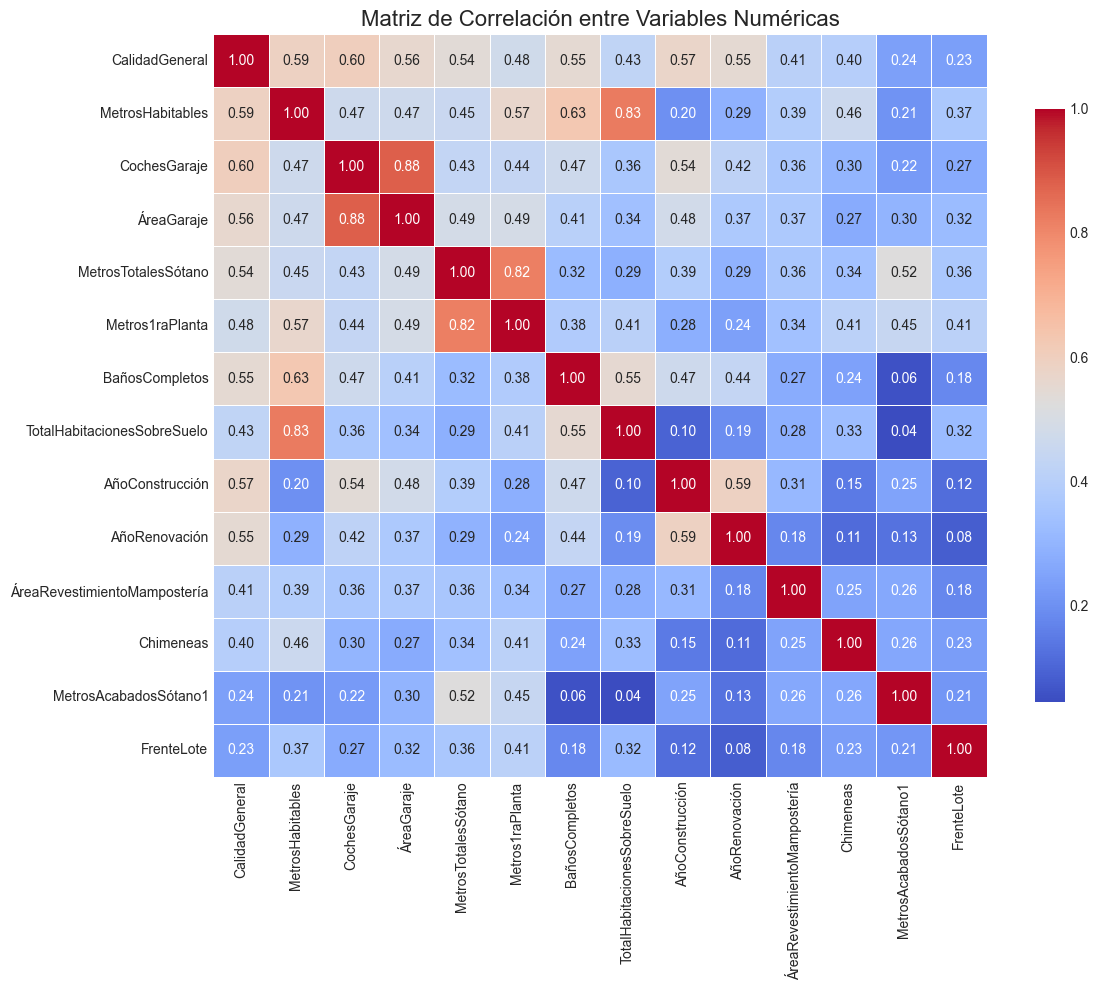

In [29]:
vars_num_importantes = [
    'CalidadGeneral',
    'MetrosHabitables',
    'CochesGaraje', 
    'ÁreaGaraje', 
    'MetrosTotalesSótano',
    'Metros1raPlanta',
    'BañosCompletos',
    'TotalHabitacionesSobreSuelo',
    'AñoConstrucción',
    'AñoRenovación',
    'ÁreaRevestimientoMampostería',
    'Chimeneas',
    'MetrosAcabadosSótano1',
    'FrenteLote'
]

# Verificamos la correlación entre estas variables numéricas y el precio transformado
correlaciones = df[vars_num_importantes + ['PrecioVenta_Log']].corr()['PrecioVenta_Log'].sort_values(ascending=False)
print("Correlaciones con el precio transformado (log):")
print(correlaciones)

# Creamos una matriz de correlación para examinar la multicolinealidad
plt.figure(figsize=(12, 10))
sns.heatmap(df[vars_num_importantes].corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

<small>

Interpretación de las Correlaciones

La matriz de correlación revela patrones importantes en nuestros datos. Después de la transformación logarítmica, las correlaciones con el precio generalmente aumentaron (CalidadGeneral subió de 0.79 a 0.82), confirmando el beneficio de esta transformación.

Encontramos varias correlaciones altas entre predictores (como el 0.88 entre CochesGaraje y ÁreaGaraje), lo que indica multicolinealidad. Esta característica justifica el uso de Ridge, ya que esta técnica está específicamente diseñada para manejar variables correlacionadas, evitando la inestabilidad que causarían en una regresión lineal simple.

La persistencia del orden de importancia de las variables después de la transformación logarítmica confirma que nuestra selección inicial de predictores sigue siendo válida para nuestro modelo.

</small>

#### **3.2. Análisis de Variables Categóricas** 

#### **3.2.1. Identificar variables categóricas e investigar su cardinalidad**

In [31]:
vars_categoricas = df.select_dtypes(include=['object']).columns.tolist()

# Analizamos la cardinalidad (número de categorías únicas) de cada variable
print(f"Total de variables categóricas: {len(vars_categoricas)}")
print("\nCardinalidad de variables categóricas:")

# Creamos un DataFrame para visualizar mejor la información de cardinalidad
cardinalidad = pd.DataFrame({
    'Variable': vars_categoricas,
    'Categorías_Únicas': [df[var].nunique() for var in vars_categoricas]
})
cardinalidad = cardinalidad.sort_values('Categorías_Únicas', ascending=False)

# Mostramos las variables categóricas ordenadas por número de categorías
print(cardinalidad)

Total de variables categóricas: 43

Cardinalidad de variables categóricas:
                        Variable  Categorías_Únicas
8                     Vecindario                 25
16                     Exterior2                 16
15                     Exterior1                 15
9                     Condición1                  9
41                     TipoVenta                  9
12                    EstiloCasa                  8
14                 MaterialTecho                  8
10                    Condición2                  8
25            TipoAcabadoSótano2                  7
24            TipoAcabadoSótano1                  7
33                    TipoGaraje                  7
31                 Funcionalidad                  7
26                   Calefacción                  6
42                CondiciónVenta                  6
36               CondiciónGaraje                  6
32               CalidadChimenea                  6
35                 CalidadGaraje         

#### **3.2.2. Transformar variables categóricas a numéricas mediante codificación**

In [ ]:
# Seleccionamos las variables categóricas con cardinalidad moderada para comenzar
# Esto evita generar demasiadas columnas con el endcoding

vars_cat_seleccionadas = ['Vecindario', 'ZonificaciónMS', 'TipoEdificio', 'EstiloCasa', 'CalidadExterior', 'TipoGaraje']